In [4]:
!nvidia-smi

Sat Apr 27 14:05:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000                On | 00000000:81:00.0 Off |                  Off |
| 30%   31C    P8               22W / 300W|      0MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
%pwd

'/manitou/pmg/projects/bys2107/gnn-mol'

In [6]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [8]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

In [10]:
DATA = Path(_dh[-1]) / "data"
DATA

PosixPath('/manitou/pmg/projects/bys2107/gnn-mol/data')

In [11]:
qm9 = QM9(root=DATA)
qm9[0]

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [14]:
!du -sh data

685M	data


In [26]:
y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0]) # WE ONLY TAKE ONE ATTRIBUTE FOR GROUND TRUTH

qm9 = qm9.shuffle()

In [38]:
# data split
data_size = 50000
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)


# normalizing the data
data_mean = qm9.data.y[0:train_index].mean()
data_std = qm9.data.y[0:train_index].std()

qm9.data.y = (qm9.data.y - data_mean) / data_std

# datasets into DataLoader
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=True)

z_loader = DataLoader(qm9[:data_size], batch_size=2, shuffle=False)

In [51]:
batch.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
class GCN(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = global_mean_pool(x, data.batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [55]:
model = GCN(10)
model

GCN(
  (conv1): GCNConv(11, 10)
  (conv2): GCNConv(10, 10)
  (conv3): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=1, bias=True)
)

In [60]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

model.training

Layer: conv1.bias, Parameters: 10
Layer: conv1.lin.weight, Parameters: 110
Layer: conv2.bias, Parameters: 10
Layer: conv2.lin.weight, Parameters: 100
Layer: conv3.bias, Parameters: 10
Layer: conv3.lin.weight, Parameters: 100
Layer: lin.weight, Parameters: 10
Layer: lin.bias, Parameters: 1
Total number of parameters: 351


True

In [94]:
class GIN(torch.nn.Module):
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(
                Linear(11, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU()
            )
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU()
            )
        )
        self.fc = Sequential(
            Linear(dim_h, dim_h),
            Linear(dim_h, 1)
        )

    def forward(self, data):
        x = data.x
        e = data.edge_index
        batch = data.batch

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(x)
        return x
        

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [75]:
def training(loader, model, criterion, optimizer):
    model.train()

    current_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        data.x = data.x.float()
        out = model(data)
        loss = criterion(out, torch.reshape(data.y, (len(data.y), 1)))
        current_loss += loss / len(loader)
        loss.backward()
        optimizer.step()
        
    return current_loss, model

In [76]:
def validation(loader, model, criterion):
    model.eval()
    val_loss = 0
    for data in loader:
        data = data.to(device)
        data.x = data.x.float()
        out = model(data)
        loss = criterion(out, torch.reshape(data.y, (len(data.y), 1)))
        val_loss += loss / len(loader)
    return val_loss

In [77]:
@torch.no_grad()
def testing(loader, model):
    criterion = torch.nn.MSELoss()
    test_loss = 0
    test_target = numpy.empty((0))
    test_y_target = numpy.empty((0))
    for data in loader:
        data = data.to(device)
        data.x = data.x.float()
        out = model(data)
        # NOTE
        # out = out.view(d.y.size())
        loss = criterion(out, torch.reshape(data.y, (len(data.y), 1)))
        test_loss += loss / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = numpy.concatenate((test_target, out.detach().cpu().numpy()[:, 0]))
        test_y_target = numpy.concatenate((test_y_target, data.y.detach().cpu().numpy()))

    return test_loss, test_target, test_y_target

In [78]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, criterion, optimizer)
        v_loss = validation(val_loader, model, criterion)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for data in train_loader:
            data = data.to(device)
            data.x = data.x.float()
            out = model(data)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = numpy.concatenate((train_target, out.detach().cpu().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, data.y.detach().cpu().numpy()))

        train_loss[epoch] = epoch_loss.detach().cpu().numpy()
        val_loss[epoch] = v_loss.detach().cpu().numpy()
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
    return train_loss, val_loss, train_target, train_y_target

In [79]:
# training GCN for 20 epochs
epochs = 20

model = GCN(dim_h=128)
model.to(device)
print(model)
gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GCN_model.pt"
)

GCN(
  (conv1): GCNConv(11, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)
Epoch: 0, Train loss: 0.8080843091011047, Val loss: 0.8119640350341797
Epoch: 2, Train loss: 0.7455629706382751, Val loss: 0.7528027296066284
Epoch: 4, Train loss: 0.7163465619087219, Val loss: 0.7164026498794556
Epoch: 6, Train loss: 0.6771403551101685, Val loss: 0.6781134605407715
Epoch: 8, Train loss: 0.6488444805145264, Val loss: 0.6466111540794373
Epoch: 10, Train loss: 0.6252313852310181, Val loss: 0.6326743960380554
Epoch: 12, Train loss: 0.6155309081077576, Val loss: 0.6388318538665771
Epoch: 14, Train loss: 0.6009238958358765, Val loss: 0.6094357967376709
Epoch: 16, Train loss: 0.6000398993492126, Val loss: 0.6190176606178284
Epoch: 18, Train loss: 0.5908594131469727, Val loss: 0.5981243252754211


In [80]:
# training GCN for 20 epochs
epochs = 50

model2 = GCN(dim_h=168)
model2.to(device)
print(model2)

gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, model2, train_loader, test_loader, "GCN_model_50.pt"
)

GCN(
  (conv1): GCNConv(11, 168)
  (conv2): GCNConv(168, 168)
  (conv3): GCNConv(168, 168)
  (lin): Linear(in_features=168, out_features=1, bias=True)
)
Epoch: 0, Train loss: 0.7920917272567749, Val loss: 0.8161768317222595
Epoch: 2, Train loss: 0.7224587798118591, Val loss: 0.7264785170555115
Epoch: 4, Train loss: 0.675578773021698, Val loss: 0.6726194024085999
Epoch: 6, Train loss: 0.6529238820075989, Val loss: 0.6705379486083984
Epoch: 8, Train loss: 0.6361660361289978, Val loss: 0.6367452144622803
Epoch: 10, Train loss: 0.6226251125335693, Val loss: 0.6541014909744263
Epoch: 12, Train loss: 0.6106582283973694, Val loss: 0.6441590189933777
Epoch: 14, Train loss: 0.5983572602272034, Val loss: 0.6062719821929932
Epoch: 16, Train loss: 0.59067702293396, Val loss: 0.5905328989028931
Epoch: 18, Train loss: 0.5792908668518066, Val loss: 0.6073458790779114
Epoch: 20, Train loss: 0.5707286596298218, Val loss: 0.5719964504241943
Epoch: 22, Train loss: 0.5674000382423401, Val loss: 0.56156259

In [97]:
model3 = GIN(dim_h=64)
model3.to(device)

model3

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5):

In [98]:
for name, param in model3.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")

total_params = sum(p.numel() for p in model3.parameters())
print(f"Total number of parameters: {total_params}")

model3.training

Layer: conv1.nn.0.weight, Parameters: 704
Layer: conv1.nn.0.bias, Parameters: 64
Layer: conv1.nn.1.weight, Parameters: 64
Layer: conv1.nn.1.bias, Parameters: 64
Layer: conv1.nn.3.weight, Parameters: 4096
Layer: conv1.nn.3.bias, Parameters: 64
Layer: conv1.nn.5.weight, Parameters: 4096
Layer: conv1.nn.5.bias, Parameters: 64
Layer: conv2.nn.0.weight, Parameters: 4096
Layer: conv2.nn.0.bias, Parameters: 64
Layer: conv2.nn.1.weight, Parameters: 64
Layer: conv2.nn.1.bias, Parameters: 64
Layer: conv2.nn.3.weight, Parameters: 4096
Layer: conv2.nn.3.bias, Parameters: 64
Layer: conv2.nn.5.weight, Parameters: 4096
Layer: conv2.nn.5.bias, Parameters: 64
Layer: conv3.nn.0.weight, Parameters: 4096
Layer: conv3.nn.0.bias, Parameters: 64
Layer: conv3.nn.1.weight, Parameters: 64
Layer: conv3.nn.1.bias, Parameters: 64
Layer: conv3.nn.3.weight, Parameters: 4096
Layer: conv3.nn.3.bias, Parameters: 64
Layer: conv3.nn.5.weight, Parameters: 4096
Layer: conv3.nn.5.bias, Parameters: 64
Layer: fc.0.weight, Par

True

In [99]:
!du -sh GCN_*

236K	GCN_model_50.pt
140K	GCN_model.pt


In [100]:
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, model3, train_loader, test_loader, "GIN_model.pt"
)

Epoch: 0, Train loss: 0.6108449697494507, Val loss: 0.5500461459159851
Epoch: 2, Train loss: 0.503491222858429, Val loss: 0.5039384365081787
Epoch: 4, Train loss: 0.47304293513298035, Val loss: 0.4273233711719513
Epoch: 6, Train loss: 0.45781034231185913, Val loss: 0.4275110065937042
Epoch: 8, Train loss: 0.4451755881309509, Val loss: 0.4014648497104645
Epoch: 10, Train loss: 0.41331946849823, Val loss: 0.3815346956253052
Epoch: 12, Train loss: 0.4027050733566284, Val loss: 0.38378384709358215
Epoch: 14, Train loss: 0.3928067982196808, Val loss: 0.3840107321739197
Epoch: 16, Train loss: 0.3923947811126709, Val loss: 0.37869036197662354
Epoch: 18, Train loss: 0.37646549940109253, Val loss: 0.36687207221984863
Epoch: 20, Train loss: 0.36934855580329895, Val loss: 0.4564181864261627
Epoch: 22, Train loss: 0.36293452978134155, Val loss: 0.4352658689022064
Epoch: 24, Train loss: 0.3572320342063904, Val loss: 0.3469196557998657
Epoch: 26, Train loss: 0.36016717553138733, Val loss: 0.33070516

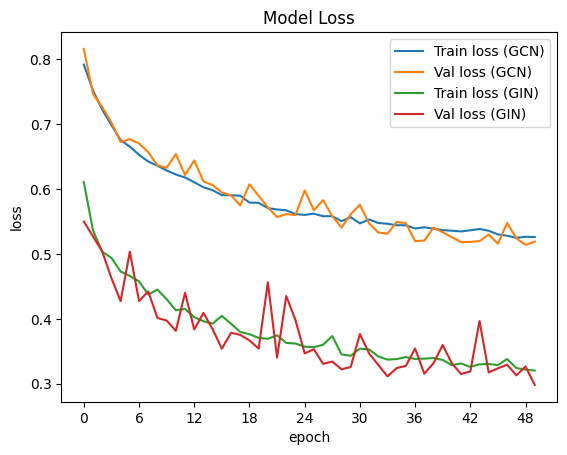

In [101]:
def plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss):
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    plt.plot(gin_train_loss, label="Train loss (GIN)")
    plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def plot_targets(pred, ground_truth):
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

# Plot overall losses of GIN and GCN

plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss)

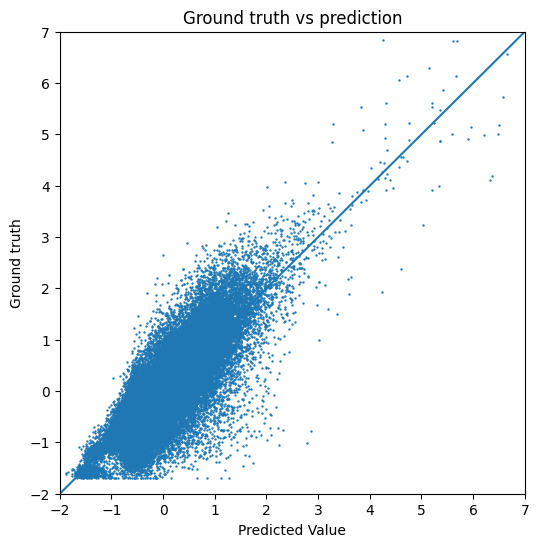

In [102]:
plot_targets(gin_train_target, gin_train_y_target)

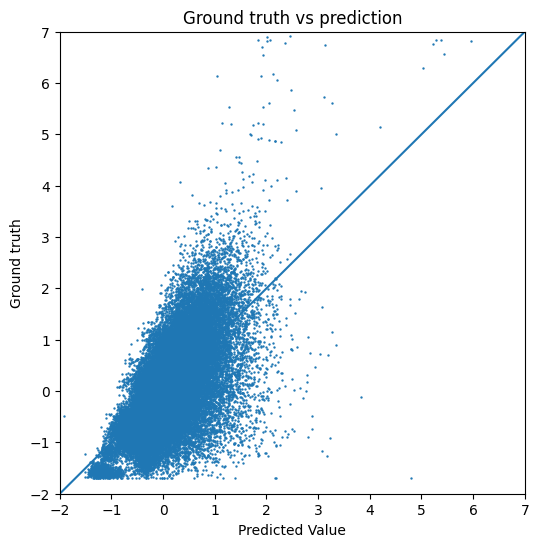

In [103]:
plot_targets(gcn_train_target, gcn_train_y_target)

Test Loss for GCN: 0.5188264846801758


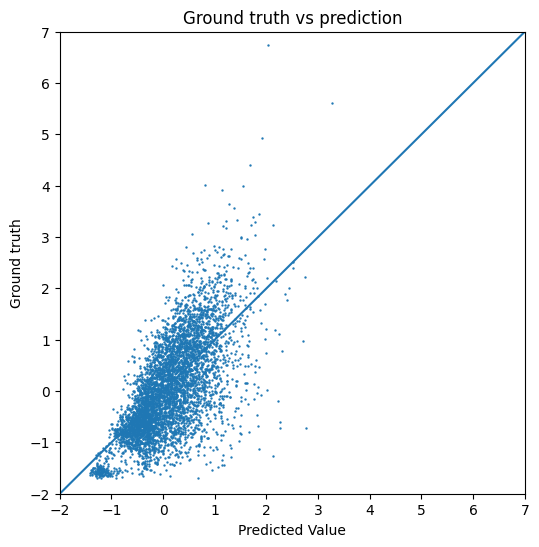

In [104]:
gcn_test_loss, gcn_test_target, gcn_test_y = testing(test_loader, model2)

print("Test Loss for GCN: " + str(gcn_test_loss.item()))
plot_targets(gcn_test_target, gcn_test_y)

Test Loss for GIN: 0.2948291301727295


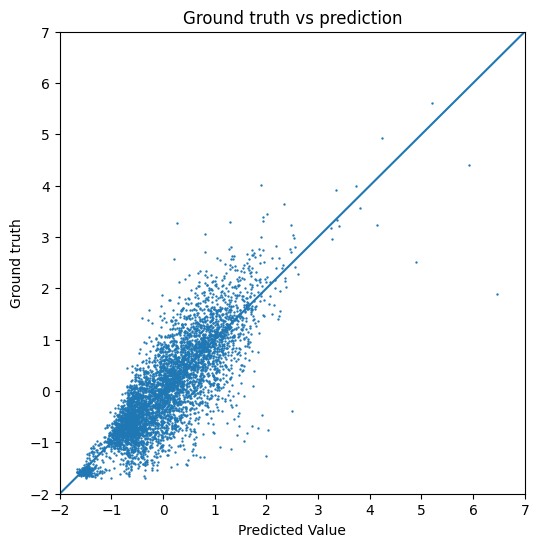

In [105]:
gin_test_loss, gin_test_target, gin_test_y = testing(test_loader, model3)

print("Test Loss for GIN: " + str(gin_test_loss.item()))
plot_targets(gin_test_target, gin_test_y)